# Advanced Operations: Paths, Distances, and Alignment

## Learning Objectives

By the end of this notebook, you will be able to:

- Calculate shortest paths through complex environments
- Understand geodesic vs Euclidean distances
- Use coordinate transformations (rotation, scaling, translation)
- Map probability distributions between different environments
- Align environments with different coordinate systems
- Apply spatial transforms to analyze remapping and context changes
- Perform graph-based spatial analysis

**Estimated time: 30-35 minutes**

## Conceptual Introduction

In real neuroscience experiments, you often need to:

1. **Measure distances** - How far did the animal travel? What's the distance between place fields?
2. **Find paths** - What route did the animal take? What's the shortest path between locations?
3. **Align environments** - Compare data from different sessions where the camera position shifted
4. **Map distributions** - Transfer place fields between slightly different discretizations

The `neurospatial` package provides powerful tools for all of these operations!

## Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from shapely.geometry import Point, Polygon

from neurospatial import Environment
from neurospatial.ops.alignment import get_2d_rotation_matrix, map_probabilities
from neurospatial.ops.transforms import Affine2D, scale_2d, translate

np.random.seed(42)
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 11

## Part 1: Shortest Paths and Geodesic Distances

### Understanding Distance Metrics

**Euclidean distance**: Straight-line distance ("as the crow flies")

**Geodesic distance**: Distance along the shortest path through the environment

These can differ significantly in complex environments with barriers or non-Euclidean layouts!

In [2]:
# Create a U-shaped environment (barrier in middle)
# Left arm
left_arm = np.random.uniform(low=[0, 0], high=[20, 60], size=(600, 2))
# Bottom connector
bottom = np.random.uniform(low=[0, 0], high=[60, 15], size=(400, 2))
# Right arm
right_arm = np.random.uniform(low=[40, 0], high=[60, 60], size=(600, 2))

u_maze_data = np.vstack([left_arm, bottom, right_arm])

env_u = Environment.from_samples(positions=u_maze_data, bin_size=4.0, name="U_Maze")

print(f"U-Maze Environment: {env_u.n_bins} bins")

U-Maze Environment: 210 bins


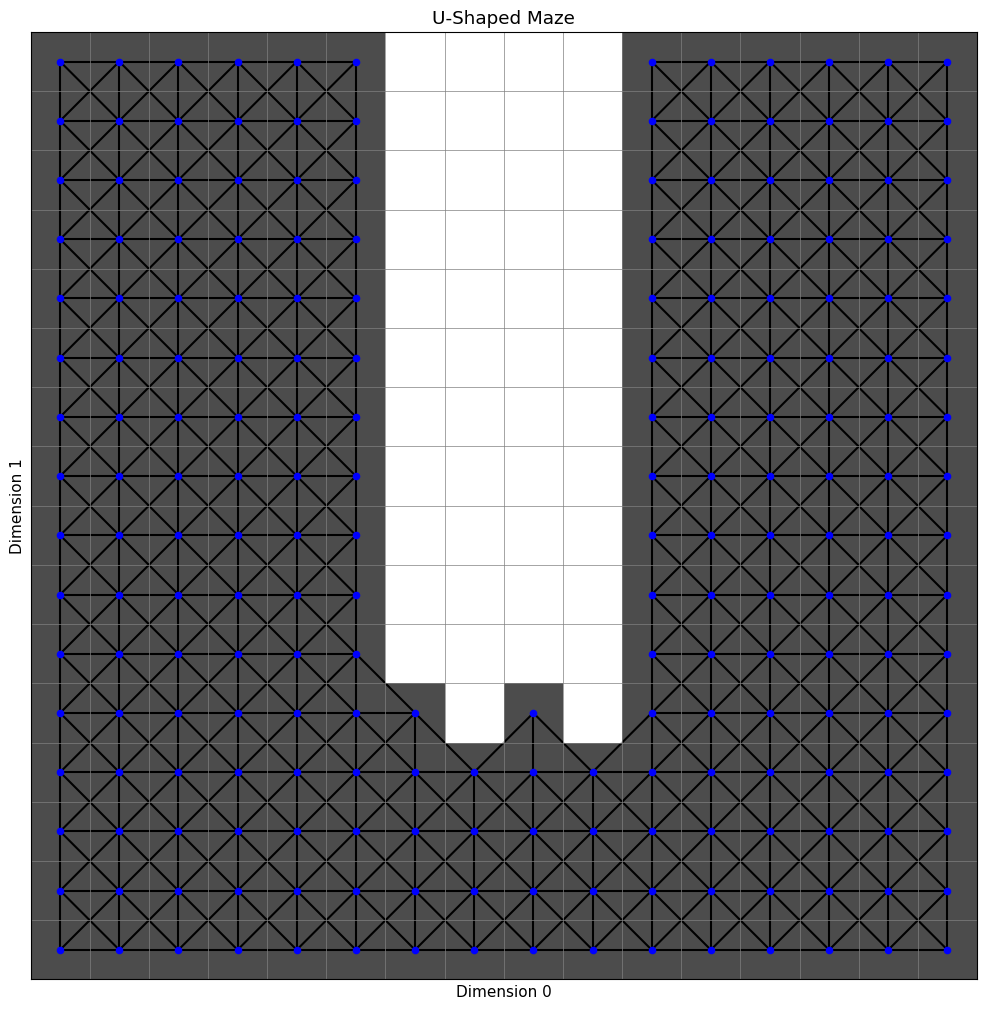

In [3]:
# Visualize the U-maze
fig, ax = plt.subplots(figsize=(10, 12))
env_u.plot(ax=ax, show_connectivity=True)
ax.set_title("U-Shaped Maze")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Comparing Euclidean vs Geodesic Distance

In [4]:
# Define two points: top of left arm and top of right arm
point_left_top = np.array([10.0, 55.0])
point_right_top = np.array([50.0, 55.0])

# Euclidean distance (straight line)
euclidean_dist = np.linalg.norm(point_right_top - point_left_top)

# Geodesic distance (through the environment)
geodesic_dist = env_u.distance_between(point_left_top, point_right_top)

print("Distance from left top to right top:")
print(f"  Euclidean (straight line): {euclidean_dist:.2f} cm")
print(f"  Geodesic (through maze):   {geodesic_dist:.2f} cm")
print(f"  Ratio (geodesic/euclidean): {geodesic_dist / euclidean_dist:.2f}x")
print(f"\nThe geodesic distance is {geodesic_dist - euclidean_dist:.2f} cm longer!")

Distance from left top to right top:
  Euclidean (straight line): 40.00 cm
  Geodesic (through maze):   110.76 cm
  Ratio (geodesic/euclidean): 2.77x

The geodesic distance is 70.76 cm longer!


### Visualizing the Shortest Path

In [5]:
# Get bins for start and end points
bin_left = env_u.bin_at(point_left_top.reshape(1, -1))[0]
bin_right = env_u.bin_at(point_right_top.reshape(1, -1))[0]

# Find shortest path
path = env_u.path_between(bin_left, bin_right)

print("\nShortest path:")
print(f"  Number of bins: {len(path)}")
print(f"  First 10 bins: {path[:10]}")


Shortest path:
  Number of bins: 25
  First 10 bins: [np.int64(46), 45, 60, 59, 58, 73, 72, 71, 70, 85]


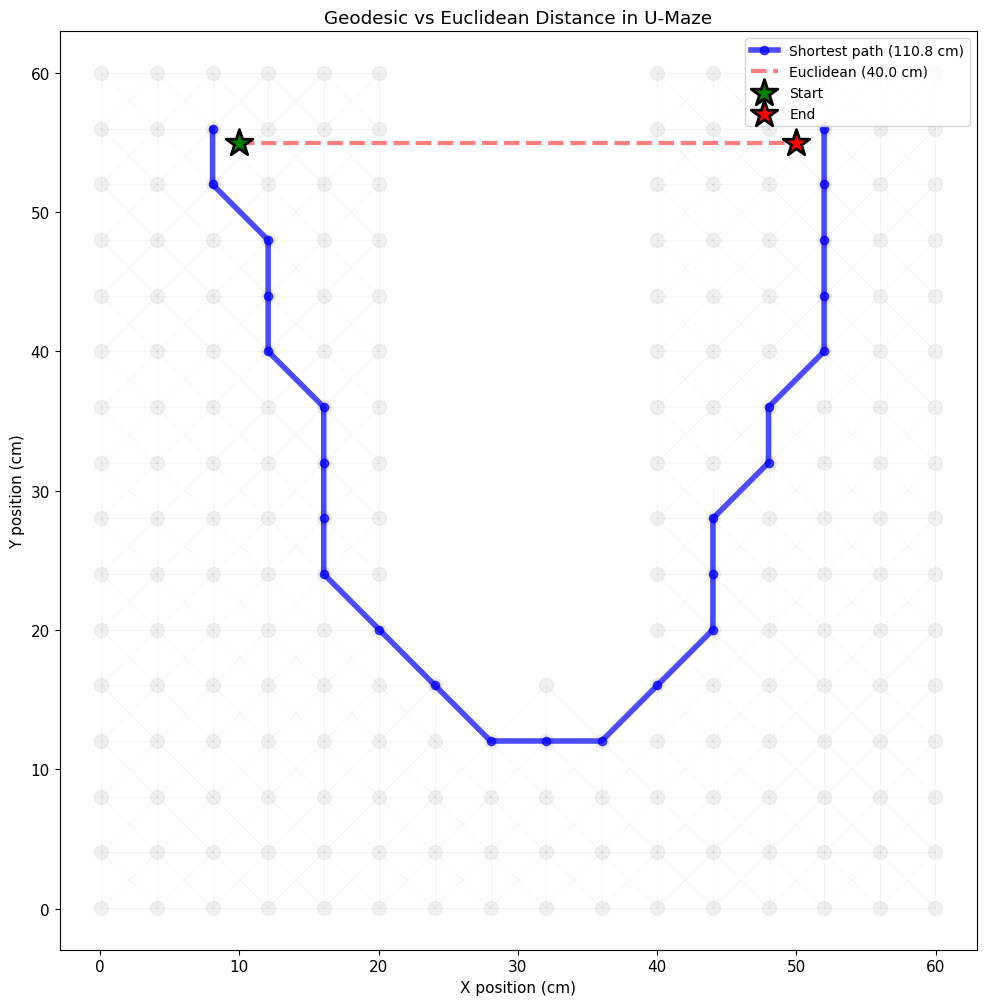

In [6]:
# Visualize the path
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all bins (faded)
ax.scatter(
    env_u.bin_centers[:, 0], env_u.bin_centers[:, 1], c="lightgray", s=100, alpha=0.3
)

# Draw edges (faded)
for edge in env_u.connectivity.edges():
    pos1 = env_u.bin_centers[edge[0]]
    pos2 = env_u.bin_centers[edge[1]]
    ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], "gray", alpha=0.1, linewidth=0.5)

# Highlight the path
path_positions = env_u.bin_centers[path]
ax.plot(
    path_positions[:, 0],
    path_positions[:, 1],
    "blue",
    linewidth=4,
    alpha=0.7,
    marker="o",
    markersize=6,
    label=f"Shortest path ({geodesic_dist:.1f} cm)",
)

# Draw straight line (Euclidean)
ax.plot(
    [point_left_top[0], point_right_top[0]],
    [point_left_top[1], point_right_top[1]],
    "r--",
    linewidth=3,
    alpha=0.5,
    label=f"Euclidean ({euclidean_dist:.1f} cm)",
)

# Mark start and end
ax.scatter(
    point_left_top[0],
    point_left_top[1],
    c="green",
    s=400,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label="Start",
    zorder=10,
)
ax.scatter(
    point_right_top[0],
    point_right_top[1],
    c="red",
    s=400,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label="End",
    zorder=10,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Geodesic vs Euclidean Distance in U-Maze")
ax.legend(loc="upper right", fontsize=10)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

**Key insight:** The animal must travel around the barrier, making the actual distance much longer than the straight-line distance!

### Analyzing Multiple Paths

In [7]:
# Calculate geodesic distances from one point to many others
reference_point = np.array([10.0, 55.0])  # Top left

# Sample test points across the environment
test_points = np.array(
    [
        [10.0, 10.0],  # Bottom left
        [30.0, 5.0],  # Bottom middle
        [50.0, 10.0],  # Bottom right
        [50.0, 30.0],  # Middle right
        [50.0, 55.0],  # Top right
    ]
)

print("\nDistances from top-left reference point:")
print(f"{'Location':<20s} {'Euclidean':>12s} {'Geodesic':>12s} {'Ratio':>8s}")
print("-" * 60)

for i, test_point in enumerate(test_points):
    euclidean = np.linalg.norm(test_point - reference_point)
    geodesic = env_u.distance_between(reference_point, test_point)
    ratio = geodesic / euclidean if euclidean > 0 else 1.0

    location = f"Point {i} {test_point}"
    print(f"{location:<20s} {euclidean:>10.2f} cm {geodesic:>10.2f} cm {ratio:>7.2f}x")


Distances from top-left reference point:
Location                Euclidean     Geodesic    Ratio
------------------------------------------------------------
Point 0 [10. 10.]         45.00 cm      47.95 cm    1.07x
Point 1 [30.  5.]         53.85 cm      60.21 cm    1.12x
Point 2 [50. 10.]         60.21 cm      77.82 cm    1.29x
Point 3 [50. 30.]         47.17 cm      82.79 cm    1.76x
Point 4 [50. 55.]         40.00 cm     110.76 cm    2.77x


## Part 2: Coordinate Transformations

Real experiments often have coordinate system issues:
- Camera rotated between sessions
- Different zoom levels (scaling)
- Arena positioned differently (translation)

The `transforms` module provides composable 2D transformations!

### Basic Transformations

In [8]:
# Create a simple square environment
square_data = np.random.uniform(0, 40, size=(1000, 2))
env_original = Environment.from_samples(
    positions=square_data, bin_size=5.0, name="Original"
)

print(f"Original environment: {env_original.n_bins} bins")
print(f"Range: {env_original.dimension_ranges}")

Original environment: 81 bins
Range: ((np.float64(-2.4760824466081877), np.float64(42.45570448133162)), (np.float64(-2.4987712461847034), np.float64(42.48230813001754)))


In [9]:
# Example 1: Translation (shift by 10 cm in x, 5 cm in y)
translation_transform = translate(10.0, 5.0)
translated_centers = translation_transform(env_original.bin_centers)

print("\nTranslation Transform:")
print(f"  Original center: {env_original.bin_centers[0]}")
print(f"  Translated center: {translated_centers[0]}")
print(f"  Shift: {translated_centers[0] - env_original.bin_centers[0]}")


Translation Transform:
  Original center: [0.02012794 0.00017761]
  Translated center: [10.02012794  5.00017761]
  Shift: [10.  5.]


In [10]:
# Example 2: Rotation (45 degrees)
# Note: There's no built-in rotate function in transforms, we use the rotation matrix
rotation_matrix = get_2d_rotation_matrix(45.0)
rotation_transform = Affine2D(
    np.array(
        [
            [rotation_matrix[0, 0], rotation_matrix[0, 1], 0],
            [rotation_matrix[1, 0], rotation_matrix[1, 1], 0],
            [0, 0, 1],
        ]
    )
)
rotated_centers = rotation_transform(env_original.bin_centers)

print("\nRotation Transform (45°):")
print(f"  Original: {env_original.bin_centers[0]}")
print(f"  Rotated: {rotated_centers[0]}")


Rotation Transform (45°):
  Original: [0.02012794 0.00017761]
  Rotated: [0.01410701 0.01435819]


In [11]:
# Example 3: Scaling (2x larger)
scaling_transform = scale_2d(2.0)
scaled_centers = scaling_transform(env_original.bin_centers)

print("\nScaling Transform (2x):")
print(f"  Original: {env_original.bin_centers[0]}")
print(f"  Scaled: {scaled_centers[0]}")


Scaling Transform (2x):
  Original: [0.02012794 0.00017761]
  Scaled: [0.04025588 0.00035522]


### Composing Transformations

The power of `Affine2D` is that you can combine transformations using the `@` operator:

In [12]:
# Compose: First scale 2x, then rotate 30°, then translate
# Note: Transformations are composed using the @ operator
rotation_30 = get_2d_rotation_matrix(30.0)
rotate_30 = Affine2D(
    np.array(
        [
            [rotation_30[0, 0], rotation_30[0, 1], 0],
            [rotation_30[1, 0], rotation_30[1, 1], 0],
            [0, 0, 1],
        ]
    )
)
composite_transform = translate(20, 10) @ rotate_30 @ scale_2d(2.0)

# Apply to bin centers
transformed_centers = composite_transform(env_original.bin_centers)

print("\nComposite Transform (scale → rotate → translate):")
print(f"  Original: {env_original.bin_centers[0]}")
print(f"  Transformed: {transformed_centers[0]}")


Composite Transform (scale → rotate → translate):
  Original: [0.02012794 0.00017761]
  Transformed: [20.034685   10.02043556]


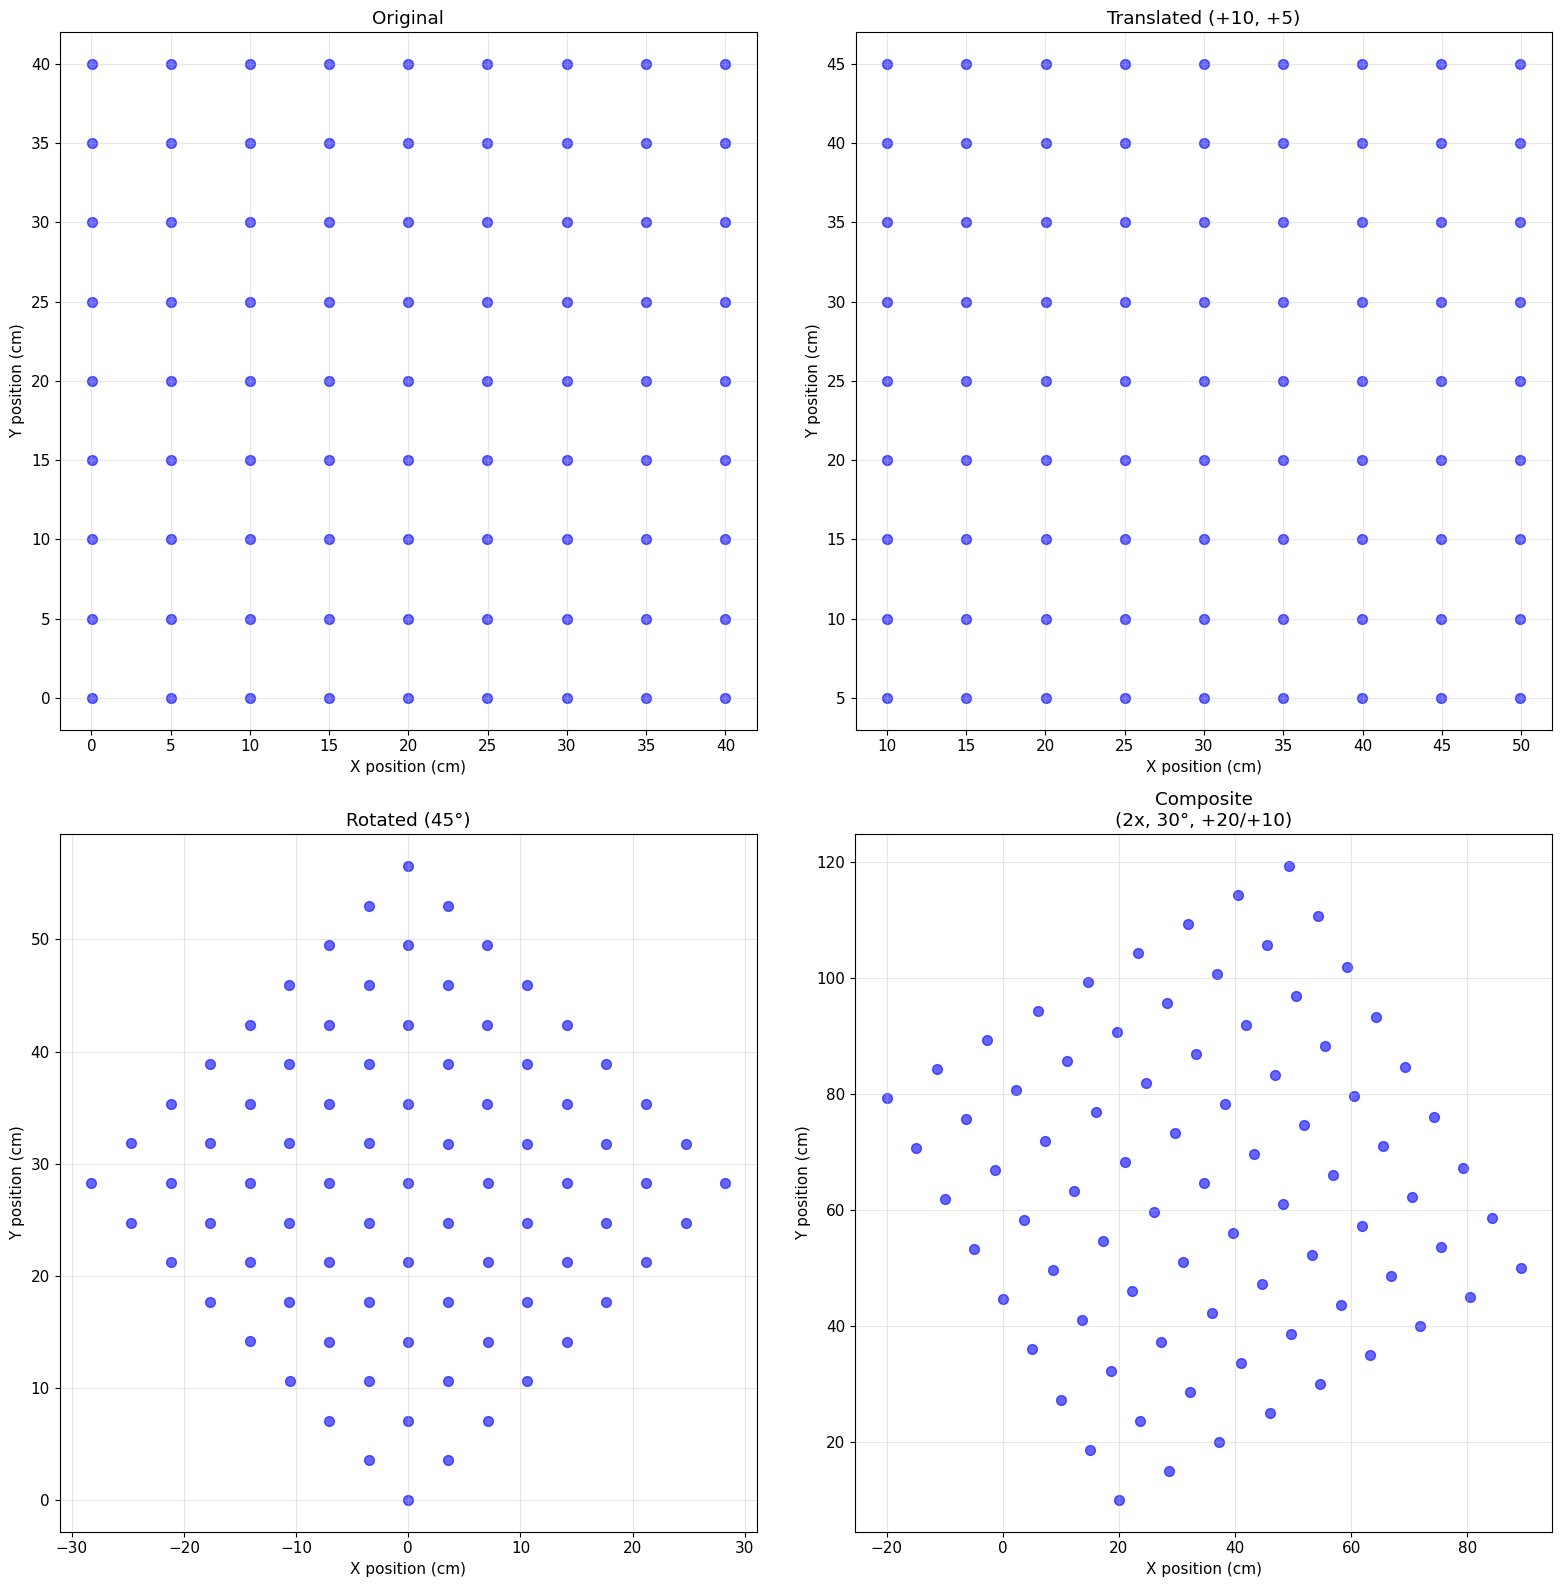

In [13]:
# Visualize the transformations
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

transforms = [
    ("Original", env_original.bin_centers),
    ("Translated (+10, +5)", translated_centers),
    ("Rotated (45°)", rotated_centers),
    ("Composite\n(2x, 30°, +20/+10)", transformed_centers),
]

for ax, (title, centers) in zip(axes, transforms, strict=False):
    ax.scatter(centers[:, 0], centers[:, 1], c="blue", s=50, alpha=0.6)
    ax.set_xlabel("X position (cm)")
    ax.set_ylabel("Y position (cm)")
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Inverse Transformations

Every transformation has an inverse that undoes it:

In [14]:
# Apply transformation
rotation_45 = get_2d_rotation_matrix(45.0)
forward = Affine2D(
    np.array(
        [
            [rotation_45[0, 0], rotation_45[0, 1], 0],
            [rotation_45[1, 0], rotation_45[1, 1], 0],
            [0, 0, 1],
        ]
    )
)
rotated = forward(env_original.bin_centers)

# Undo with inverse
backward = forward.inverse()
restored = backward(rotated)

# Verify they match
max_error = np.abs(restored - env_original.bin_centers).max()

print("\nInverse Transform:")
print(f"  Original: {env_original.bin_centers[0]}")
print(f"  Rotated: {rotated[0]}")
print(f"  Restored: {restored[0]}")
print(f"  Max error: {max_error:.10f} (should be ~0)")


Inverse Transform:
  Original: [0.02012794 0.00017761]
  Rotated: [0.01410701 0.01435819]
  Restored: [0.02012794 0.00017761]
  Max error: 0.0000000000 (should be ~0)


## Part 3: Mapping Probability Distributions

A common neuroscience task: you have a place field (neural firing rate map) in one discretization, and you need to map it to another discretization.

**Use cases:**
- Compare place fields across sessions with slightly different bin sizes
- Align data from rotated/shifted environments
- Map predictions from one resolution to another

### Example: Mapping Between Different Bin Sizes

In [15]:
# Create two environments with different bin sizes
circle = Point(50, 50).buffer(25)

# Fine discretization (3 cm bins)
env_fine = Environment.from_polygon(polygon=circle, bin_size=3.0, name="Fine")

# Coarse discretization (6 cm bins)
env_coarse = Environment.from_polygon(polygon=circle, bin_size=6.0, name="Coarse")

print(f"Fine environment: {env_fine.n_bins} bins (3 cm)")
print(f"Coarse environment: {env_coarse.n_bins} bins (6 cm)")

Fine environment: 225 bins (3 cm)
Coarse environment: 69 bins (6 cm)


In [16]:
# Create a synthetic "place field" - Gaussian bump in the fine environment
place_field_center = np.array([60.0, 55.0])  # Off-center
sigma = 8.0  # Width of place field

# Calculate Gaussian firing rate at each bin
distances_to_center = np.linalg.norm(env_fine.bin_centers - place_field_center, axis=1)
firing_rates_fine = np.exp(-(distances_to_center**2) / (2 * sigma**2))

# Normalize to be a probability distribution
firing_probs_fine = firing_rates_fine / firing_rates_fine.sum()

print("\nPlace field statistics (fine):")
print(f"  Total probability: {firing_probs_fine.sum():.6f}")
print(f"  Max probability: {firing_probs_fine.max():.6f}")
print(f"  Mean probability: {firing_probs_fine.mean():.6f}")


Place field statistics (fine):
  Total probability: 1.000000
  Max probability: 0.022762
  Mean probability: 0.004444


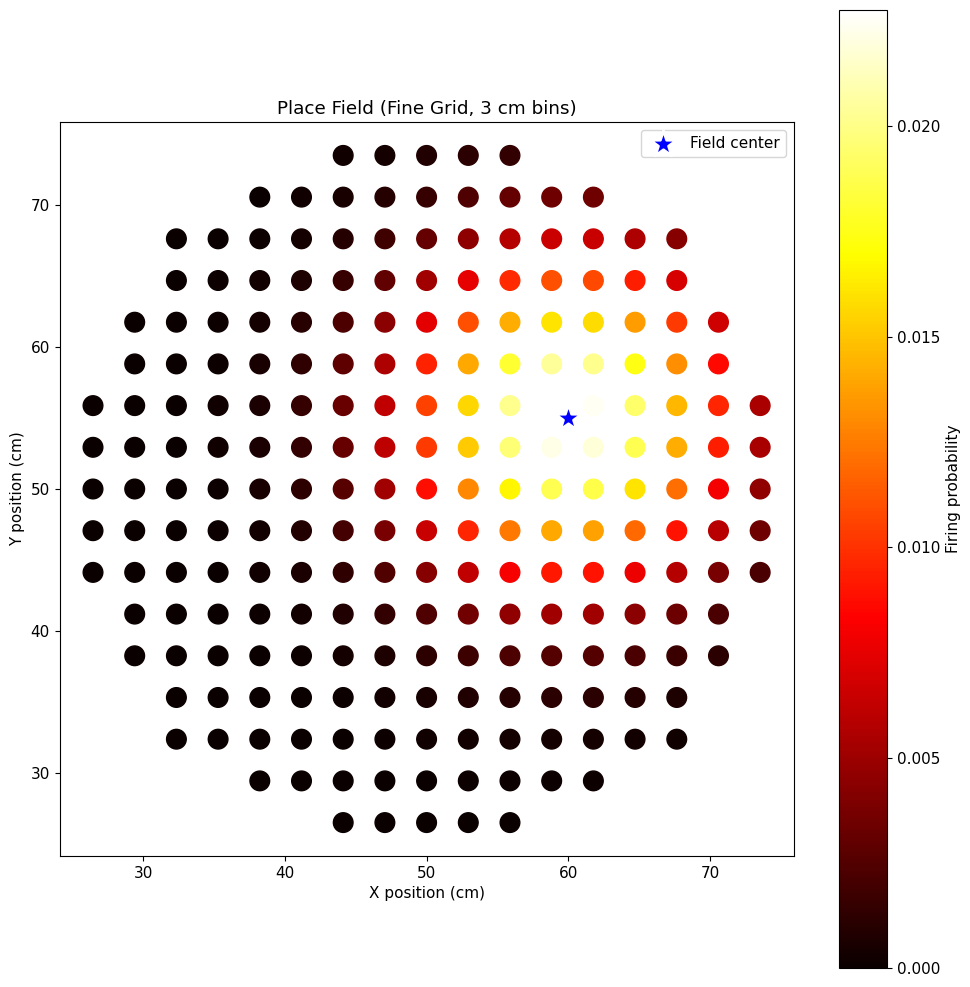

In [17]:
# Visualize the place field on fine grid
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    env_fine.bin_centers[:, 0],
    env_fine.bin_centers[:, 1],
    c=firing_probs_fine,
    s=200,
    cmap="hot",
    vmin=0,
    vmax=firing_probs_fine.max(),
)

ax.scatter(
    place_field_center[0],
    place_field_center[1],
    c="blue",
    s=400,
    marker="*",
    edgecolors="white",
    linewidth=2,
    label="Field center",
)

plt.colorbar(scatter, ax=ax, label="Firing probability")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Place Field (Fine Grid, 3 cm bins)")
ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Map the probabilities to the coarse grid
firing_probs_coarse = map_probabilities(
    source_env=env_fine,
    target_env=env_coarse,
    source_probs=firing_probs_fine,
    mode="nearest",  # Map each source bin to nearest target bin
)

print("\nPlace field statistics (coarse):")
print(f"  Total probability: {firing_probs_coarse.sum():.6f}")
print(f"  Max probability: {firing_probs_coarse.max():.6f}")
print(f"  Mean probability: {firing_probs_coarse.mean():.6f}")


Place field statistics (coarse):
  Total probability: 1.000000
  Max probability: 0.089230
  Mean probability: 0.014493


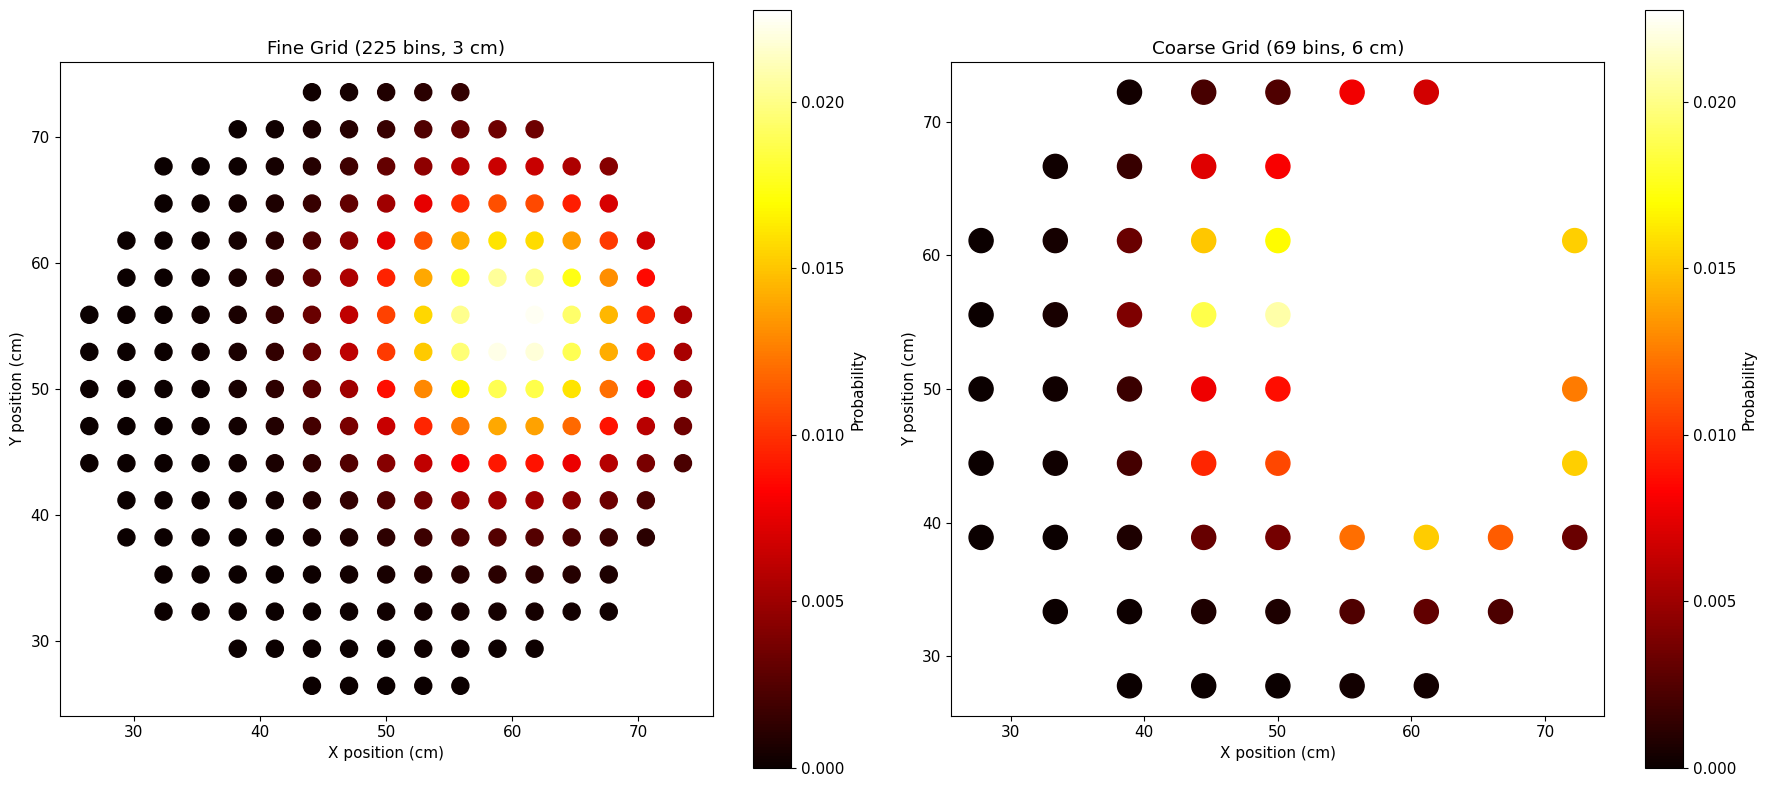

In [19]:
# Compare fine and coarse
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Fine grid
scatter1 = axes[0].scatter(
    env_fine.bin_centers[:, 0],
    env_fine.bin_centers[:, 1],
    c=firing_probs_fine,
    s=150,
    cmap="hot",
    vmin=0,
    vmax=firing_probs_fine.max(),
)
axes[0].set_title(f"Fine Grid ({env_fine.n_bins} bins, 3 cm)")
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")
axes[0].set_aspect("equal")
plt.colorbar(scatter1, ax=axes[0], label="Probability")

# Coarse grid
scatter2 = axes[1].scatter(
    env_coarse.bin_centers[:, 0],
    env_coarse.bin_centers[:, 1],
    c=firing_probs_coarse,
    s=300,
    cmap="hot",
    vmin=0,
    vmax=firing_probs_fine.max(),  # Use same scale
)
axes[1].set_title(f"Coarse Grid ({env_coarse.n_bins} bins, 6 cm)")
axes[1].set_xlabel("X position (cm)")
axes[1].set_ylabel("Y position (cm)")
axes[1].set_aspect("equal")
plt.colorbar(scatter2, ax=axes[1], label="Probability")

plt.tight_layout()
plt.show()

**Note:** The probability is preserved (sums to ~1.0), but distributed over fewer, larger bins in the coarse grid.

### Example: Mapping Between Rotated Environments

In [20]:
# Create rotated version of the fine environment
# Simulate camera rotation between sessions
rotation_angle = 45.0  # degrees

# Apply rotation to bin centers to create "Session 2" data
rotation_matrix = get_2d_rotation_matrix(rotation_angle)
rotation = Affine2D(
    np.array(
        [
            [rotation_matrix[0, 0], rotation_matrix[0, 1], 0],
            [rotation_matrix[1, 0], rotation_matrix[1, 1], 0],
            [0, 0, 1],
        ]
    )
)
rotated_centers = rotation(env_fine.bin_centers)

# Create environment from rotated bin centers
# (In practice, you'd have new data from Session 2)
env_rotated = Environment.from_samples(
    positions=rotated_centers, bin_size=3.0, name="Session2_Rotated"
)

print(f"\nRotated environment: {env_rotated.n_bins} bins")


Rotated environment: 188 bins


In [21]:
# Map place field from Session 1 to Session 2 coordinates
# Transform Session 1 bin centers to Session 2 coordinates using the rotation transform
transformed_bin_centers = rotation(env_fine.bin_centers)

# Now map probabilities
# (This is more complex - we're showing the concept)
print("\nConcept: Place field mapping across rotated sessions")
print("  Session 1 (original): Place field centered at", place_field_center)
print("  Session 2 (45° rotation): Would need to transform center and remap")
print("\nThis is useful for analyzing place field stability across contexts!")


Concept: Place field mapping across rotated sessions
  Session 1 (original): Place field centered at [60. 55.]
  Session 2 (45° rotation): Would need to transform center and remap

This is useful for analyzing place field stability across contexts!


## Part 4: Graph Analysis

Since environments are based on NetworkX graphs, you can use graph analysis tools!

In [22]:
# Create a complex environment for graph analysis
polygon_coords = [
    (0, 0),
    (50, 0),
    (50, 20),
    (30, 20),
    (30, 40),
    (50, 40),
    (50, 60),
    (0, 60),
    (0, 40),
    (20, 40),
    (20, 20),
    (0, 20),
]
complex_polygon = Polygon(polygon_coords)

env_complex = Environment.from_polygon(
    polygon=complex_polygon, bin_size=4.0, name="ComplexMaze"
)

print(f"Complex maze: {env_complex.n_bins} bins")
print(f"Edges: {env_complex.connectivity.number_of_edges()}")

Complex maze: 145 bins
Edges: 472


In [23]:
# Graph metrics
print("\nGraph Metrics:")
print(f"  Number of nodes: {env_complex.connectivity.number_of_nodes()}")
print(f"  Number of edges: {env_complex.connectivity.number_of_edges()}")
print(f"  Is connected: {nx.is_connected(env_complex.connectivity)}")
print(
    f"  Average degree: {sum(dict(env_complex.connectivity.degree()).values()) / env_complex.n_bins:.2f}"
)


Graph Metrics:
  Number of nodes: 145
  Number of edges: 472
  Is connected: True
  Average degree: 6.51


In [24]:
# Find boundary nodes (bins on the edge of the environment)
# These have fewer neighbors than interior bins
degree_dict = dict(env_complex.connectivity.degree())
degrees = np.array([degree_dict[i] for i in range(env_complex.n_bins)])

# In a regular grid, interior nodes have 8 neighbors (with diagonal)
# Boundary nodes have fewer
is_boundary = degrees < degrees.max()
n_boundary = is_boundary.sum()

print("\nBoundary Analysis:")
print(f"  Max degree (interior): {degrees.max()}")
print(f"  Boundary bins: {n_boundary} ({100 * n_boundary / env_complex.n_bins:.1f}%)")
print(f"  Interior bins: {env_complex.n_bins - n_boundary}")


Boundary Analysis:
  Max degree (interior): 8
  Boundary bins: 72 (49.7%)
  Interior bins: 73


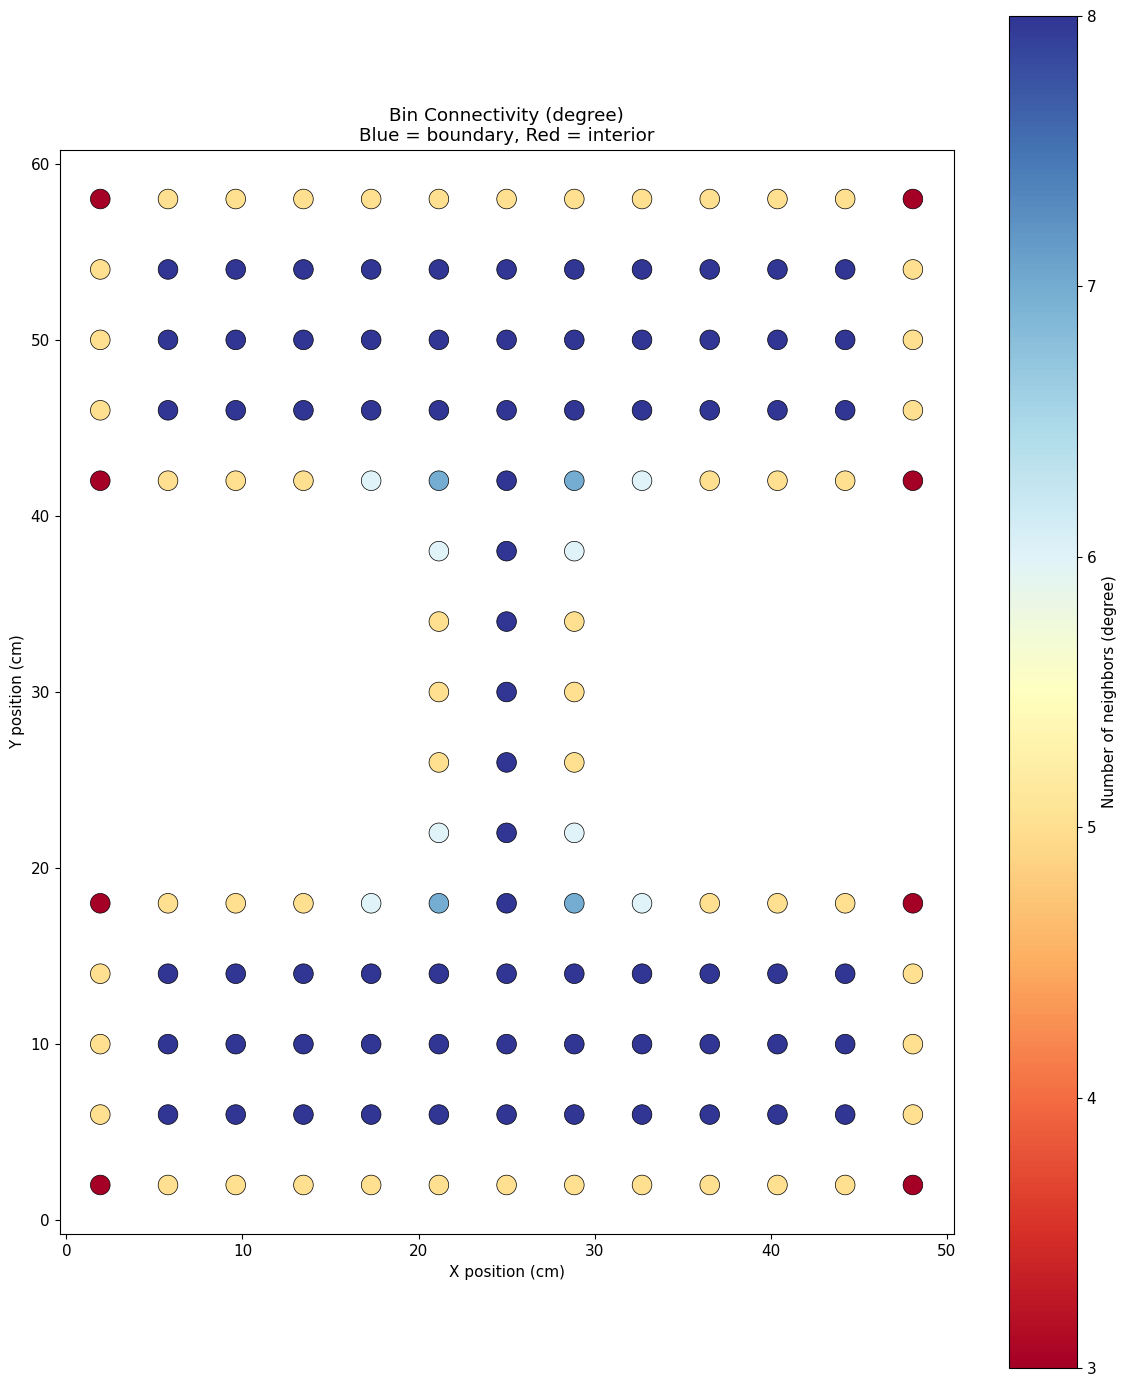

In [25]:
# Visualize boundary vs interior
fig, ax = plt.subplots(figsize=(12, 14))

# Color by degree (number of neighbors)
scatter = ax.scatter(
    env_complex.bin_centers[:, 0],
    env_complex.bin_centers[:, 1],
    c=degrees,
    s=200,
    cmap="RdYlBu",
    edgecolors="black",
    linewidth=0.5,
)

plt.colorbar(scatter, ax=ax, label="Number of neighbors (degree)")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Bin Connectivity (degree)\nBlue = boundary, Red = interior")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Centrality Measures

Graph centrality can identify "important" locations in an environment:

In [26]:
# Calculate betweenness centrality
# (measures how often a node appears on shortest paths)
betweenness = nx.betweenness_centrality(env_complex.connectivity, weight="distance")
betweenness_array = np.array([betweenness[i] for i in range(env_complex.n_bins)])

# Find most central bins
top_5_indices = np.argsort(betweenness_array)[-5:]

print("\nTop 5 Most Central Bins (betweenness):")
for i, idx in enumerate(top_5_indices[::-1]):
    pos = env_complex.bin_centers[idx]
    centrality = betweenness_array[idx]
    print(f"  {i + 1}. Bin {idx} at {pos}: centrality={centrality:.4f}")


Top 5 Most Central Bins (betweenness):
  1. Bin 55 at [21.15384615 22.        ]: centrality=0.2115
  2. Bin 59 at [21.15384615 38.        ]: centrality=0.2115
  3. Bin 89 at [28.84615385 38.        ]: centrality=0.2103
  4. Bin 85 at [28.84615385 22.        ]: centrality=0.2103
  5. Bin 58 at [21.15384615 34.        ]: centrality=0.1772


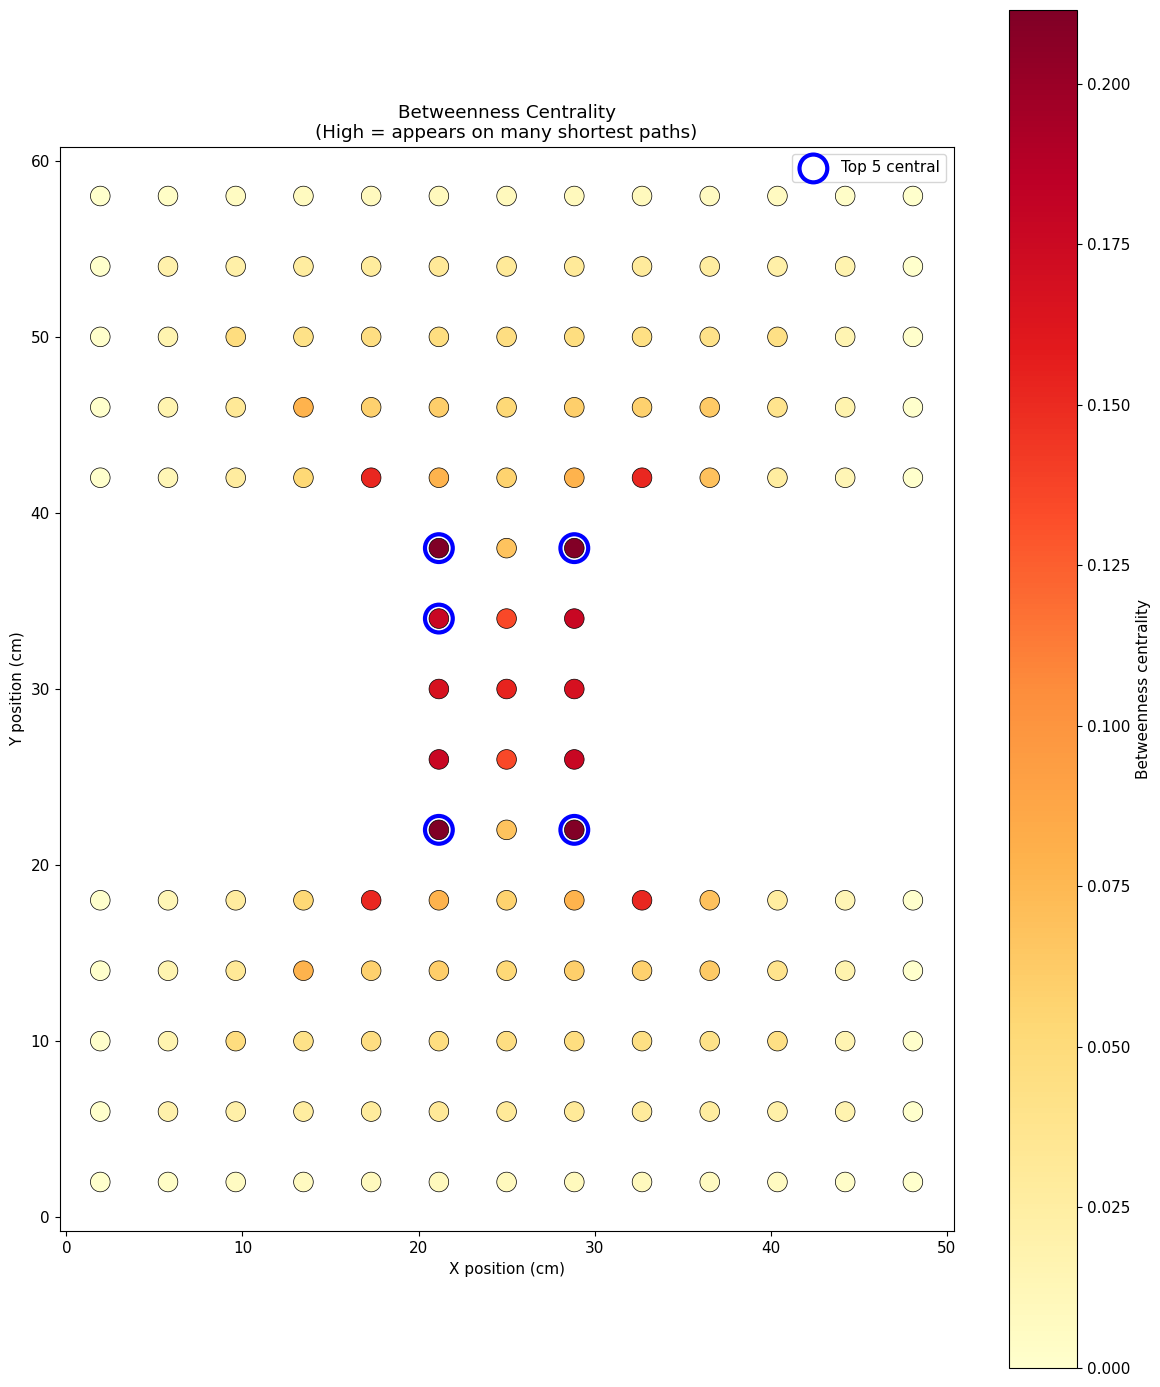

In [27]:
# Visualize centrality
fig, ax = plt.subplots(figsize=(12, 14))

scatter = ax.scatter(
    env_complex.bin_centers[:, 0],
    env_complex.bin_centers[:, 1],
    c=betweenness_array,
    s=200,
    cmap="YlOrRd",
    edgecolors="black",
    linewidth=0.5,
)

# Highlight top central bins
ax.scatter(
    env_complex.bin_centers[top_5_indices, 0],
    env_complex.bin_centers[top_5_indices, 1],
    s=400,
    facecolors="none",
    edgecolors="blue",
    linewidth=3,
    label="Top 5 central",
)

plt.colorbar(scatter, ax=ax, label="Betweenness centrality")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Betweenness Centrality\n(High = appears on many shortest paths)")
ax.legend()
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

**Interpretation:** High centrality bins are "bottlenecks" - the animal must pass through them to travel between many locations. These might correspond to junctions in mazes or doorways in multi-room environments.

## Common Pitfalls and Best Practices

### Pitfall 1: Forgetting to normalize probabilities

In [28]:
# When mapping probabilities, they should sum to 1.0
# If they don't, normalize them first!

firing_rates = np.random.rand(env_fine.n_bins)  # Raw firing rates
print(f"Raw firing rates sum: {firing_rates.sum():.4f}")

# Normalize
firing_probs_normalized = firing_rates / firing_rates.sum()
print(f"Normalized probabilities sum: {firing_probs_normalized.sum():.4f}")

print("\n✓ Always normalize to probabilities before mapping!")

Raw firing rates sum: 112.9080
Normalized probabilities sum: 1.0000

✓ Always normalize to probabilities before mapping!


### Pitfall 2: Transform order matters!

In [29]:
# Transforms are applied RIGHT TO LEFT
test_point = np.array([[10.0, 10.0]])

# Scale then translate
transform1 = translate(10, 10) @ scale_2d(2.0)
result1 = transform1(test_point)

# Translate then scale (different!)
transform2 = scale_2d(2.0) @ translate(10, 10)
result2 = transform2(test_point)

print("Transform order matters:")
print(f"  Original: {test_point[0]}")
print(f"  Scale → Translate: {result1[0]}")
print(f"  Translate → Scale: {result2[0]}")
print("\n✓ Be explicit about order: compose left-to-right, applies right-to-left")

Transform order matters:
  Original: [10. 10.]
  Scale → Translate: [30. 30.]
  Translate → Scale: [40. 40.]

✓ Be explicit about order: compose left-to-right, applies right-to-left


### Best Practice: Verify transformations visually

In [30]:
print("\n✓ Always plot original and transformed coordinates to verify")
print("✓ Check that inverse transforms restore original data")
print("✓ Use test points with known expected results")


✓ Always plot original and transformed coordinates to verify
✓ Check that inverse transforms restore original data
✓ Use test points with known expected results


## Key Takeaways

Congratulations! You've mastered advanced neurospatial operations:

1. **Shortest paths** find routes through complex environments
   - Use `path_between(bin1, bin2)` for bin sequences
   - Returns list of bin indices along the path

2. **Geodesic distance** measures actual travel distance along connectivity graph
   - Use `distance_between(point1, point2)`
   - Can differ significantly from Euclidean distance in complex spaces

3. **Coordinate transformations** handle rotations, scaling, translation
   - Use `Affine2D` class for transformations
   - Compose transformations: `translate(10, 5) @ rotate_transform @ scale_2d(2)`
   - Every transform has `.inverse()` to undo it

4. **Probability mapping** transfers distributions between environments
   - Use `map_probabilities()`
   - Preserves total probability while changing discretization
   - Useful for comparing place fields across sessions

5. **Graph analysis** reveals environment structure
   - Degree centrality: number of neighbors
   - Betweenness centrality: bottlenecks and junctions
   - Use NetworkX functions on `env.connectivity`

## Next Steps

In the final notebook (**08_complete_workflow.ipynb**), you'll see:
- Complete end-to-end neuroscience analysis pipeline
- Raw tracking data → place fields → occupancy normalization
- Multi-region analysis and comparisons
- Integration of all concepts from previous notebooks
- Real-world best practices and workflows

## Exercises (Optional)

1. Create a figure-8 maze and calculate geodesic distances between all junction points
2. Design a transformation that rotates 90° around a specific point (not origin)
3. Map a place field from a hexagonal to a regular grid layout
4. Find the bin with highest betweenness centrality in a T-maze and explain why
5. Create two rotated versions of an environment and verify probability mapping preserves total mass